In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#Read data files
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample_submission = pd.read_csv('sample_submission_kaggle.csv')
extra_infos = pd.read_json('extra_infos.json',lines=True)

In [4]:

# This function computes the mean, for each user, of is_listened 
# (for flow only, and for all), and returns the original dataframe
# with additionnal columns, 'avg_per_user_all' and 'avg_per_user_flow'
# Remark: The second argument of the function can be train if we just 
#         want to add columns to train, but also to test for instance (to submit directly)
# The function returns the dictionnaries list_users_frequency_all and list_users_frequency_flow,
# and the uploaded dataframe (df with additionnal columns)
def predict_with_user_frequency_given_flow(train,df):
    list_users = test['user_id'].unique() #for which user, we will compute the frequency of listened in flow mode
    
    #Average on all songs
    list_users_frequency_all = {}
    print("Computation 1/2...")
    for i,user in enumerate(list_users):
        if i % int(len(list_users)/20) == 0:
            print('Computing ----- %f %%' % int(i*100/len(list_users)))
        train_user = train.loc[train['user_id'] == user] #we select the user
        frequency = train_user['is_listened'].mean()
        list_users_frequency_all[user] = frequency
        
    
    #Average on song with Flow (listen_type = 1)
    list_users_frequency_flow = {}
    print("Computation 2/2...")
    train_flow = train.loc[train['listen_type'] == 1]
    for i,user in enumerate(list_users):
        if i % int(len(list_users)/20) == 0:
            print('Computing ----- %f %%' % int(i*100/len(list_users)))
        train_flow_user = train_flow.loc[train_flow['user_id'] == user] #we select the user
        
        if len(train_flow_user) == 0: #user not in train_flow
            #We take the frequency for non-flow (because we only have this information)
            train_user = train.loc[train['user_id'] == user]
            if len(train_flow_user) == 0: #user not either in train_flow
                frequency = 1 #maybe put rather the mean frequency for all people?
            else:
                frequency = train_user['is_listened'].mean()
        else: #Normal case
            frequency = train_flow_user['is_listened'].mean()
        list_users_frequency_flow[user] = frequency
#     print(list_users_frequency)

    #--------At this point, list_users_frequency_all and list_users_frequency_flow give-----------------
    #--------us the correspondance between users and the frequencies that we were looking for-----------
    
    
    #Create the new columns from list_users_frequency_all and list_users_frequency_flow
    def predict_is_listened(row,list_users_frequency):
        return list_users_frequency[row['user_id']]
    df['avg_per_user_all'] = df.apply(lambda row: predict_is_listened(row,list_users_frequency_all),axis=1)
    df['avg_per_user_flow'] = df.apply(lambda row: predict_is_listened(row,list_users_frequency_flow),axis=1)
    return df,list_users_frequency_flow,list_users_frequency_all

In [7]:

#Example
new_train,list_users_frequency_flow,list_users_frequency_all =\
            predict_with_user_frequency_given_flow(train,train)
#New train is the old train, with 2 new columns

Computation 1/2...
Computing ----- 0.000000 %
Computing ----- 4.000000 %
Computing ----- 9.000000 %
Computing ----- 14.000000 %
Computing ----- 19.000000 %
Computing ----- 24.000000 %
Computing ----- 29.000000 %
Computing ----- 34.000000 %
Computing ----- 39.000000 %
Computing ----- 44.000000 %
Computing ----- 49.000000 %
Computing ----- 54.000000 %
Computing ----- 59.000000 %
Computing ----- 64.000000 %
Computing ----- 69.000000 %
Computing ----- 74.000000 %
Computing ----- 79.000000 %
Computing ----- 84.000000 %
Computing ----- 89.000000 %
Computing ----- 94.000000 %
Computing ----- 99.000000 %
Computation 2/2...
Computing ----- 0.000000 %
Computing ----- 4.000000 %
Computing ----- 9.000000 %
Computing ----- 14.000000 %
Computing ----- 19.000000 %
Computing ----- 24.000000 %
Computing ----- 29.000000 %
Computing ----- 34.000000 %
Computing ----- 39.000000 %
Computing ----- 44.000000 %
Computing ----- 49.000000 %
Computing ----- 54.000000 %
Computing ----- 59.000000 %
Computing ----- 

# Submission, using avg_per_user_flow: 

## 1- Cross-validation

In [14]:
#This function separates train_set from cross_validation_set as follows:
# it separates songs in flow mode, and puts 20% in test_train.
# The rest of the flow mode goes in train_train, with also all non-flow songs
def separate_train_cross_val(train, ratio=0.8): 
#todo: What we want = separate in order to have once (and only once) each user in the test set
    train_flow = train.loc[train['listen_type'] == 1]
    train_non_flow = train.loc[train['listen_type'] == 0]
    msk = np.random.rand(len(train_flow)) < ratio
    train_train = pd.concat([train_flow[msk],train_non_flow])
    test_train = train_flow[~msk] #cross validation set. Only has flow mode (i.e. listen_type = 1)
    return train_train,test_train


train_train,test_train = separate_train_cross_val(train)


test_train,list_users_frequency_flow,list_users_frequency_all =\
        predict_with_user_frequency_given_flow(train_train,test_train)

Computation 1/2...
Computing ----- 0.000000 %
Computing ----- 4.000000 %
Computing ----- 9.000000 %
Computing ----- 14.000000 %
Computing ----- 19.000000 %
Computing ----- 24.000000 %
Computing ----- 29.000000 %
Computing ----- 34.000000 %
Computing ----- 39.000000 %
Computing ----- 44.000000 %
Computing ----- 49.000000 %
Computing ----- 54.000000 %
Computing ----- 59.000000 %
Computing ----- 64.000000 %
Computing ----- 69.000000 %
Computing ----- 74.000000 %
Computing ----- 79.000000 %
Computing ----- 84.000000 %
Computing ----- 89.000000 %
Computing ----- 94.000000 %
Computing ----- 99.000000 %
Computation 2/2...
Computing ----- 0.000000 %
Computing ----- 4.000000 %
Computing ----- 9.000000 %
Computing ----- 14.000000 %
Computing ----- 19.000000 %
Computing ----- 24.000000 %
Computing ----- 29.000000 %
Computing ----- 34.000000 %
Computing ----- 39.000000 %
Computing ----- 44.000000 %
Computing ----- 49.000000 %
Computing ----- 54.000000 %
Computing ----- 59.000000 %
Computing ----- 

ROC AUC = 0.839048994788
[ 0.          0.0023829   0.0023829  ...,  0.99110455  0.99132558  1.        ]
[ 0.          0.02111659  0.02237058 ...,  0.99930294  0.99930653  1.        ]
[ 2.          1.          0.99927061 ...,  0.00595238  0.00574713  0.        ]


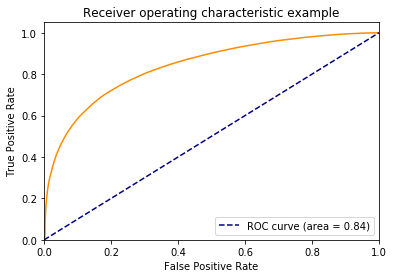

In [16]:
prediction = test_train['avg_per_user_flow']


y_true = test_train['is_listened']
y_scores = prediction

print("ROC AUC =",roc_auc_score(y_true, y_scores))
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)
print(fpr)
print(tpr)
print(thresholds)

plt.plot(fpr, tpr,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, y_scores))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Code for submission

In [17]:
test,list_users_frequency_flow,list_users_frequency_all =\
        predict_with_user_frequency_given_flow(train,test)
prediction_submission = test['avg_per_user_flow']

#------------------Put into csv-----------------------------
submission = sample_submission.copy()
print(submission.columns)
submission['is_listened'] = prediction_submission
# print(submission)
print(submission.columns)
submission.to_csv('submission.csv',index=False)

Computation 1/2...
Computing ----- 0.000000 %
Computing ----- 4.000000 %
Computing ----- 9.000000 %
Computing ----- 14.000000 %
Computing ----- 19.000000 %
Computing ----- 24.000000 %
Computing ----- 29.000000 %
Computing ----- 34.000000 %
Computing ----- 39.000000 %
Computing ----- 44.000000 %
Computing ----- 49.000000 %
Computing ----- 54.000000 %
Computing ----- 59.000000 %
Computing ----- 64.000000 %
Computing ----- 69.000000 %
Computing ----- 74.000000 %
Computing ----- 79.000000 %
Computing ----- 84.000000 %
Computing ----- 89.000000 %
Computing ----- 94.000000 %
Computing ----- 99.000000 %
Computation 2/2...
Computing ----- 0.000000 %
Computing ----- 4.000000 %
Computing ----- 9.000000 %
Computing ----- 14.000000 %
Computing ----- 19.000000 %
Computing ----- 24.000000 %
Computing ----- 29.000000 %
Computing ----- 34.000000 %
Computing ----- 39.000000 %
Computing ----- 44.000000 %
Computing ----- 49.000000 %
Computing ----- 54.000000 %
Computing ----- 59.000000 %
Computing ----- 